In [1]:
from networks import *
from nerf import *
import utils as ut
import matplotlib.pyplot as plt  
import os 
from calibrate import *



In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    device = torch.device('cpu')
    print("No GPU available, using CPU")

No GPU available, using CPU


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [4]:
# ============================================================================
# PATH CONFIGURATION
# ============================================================================
# Update these paths according to your directory structure
# All paths are relative to the notebook's directory

# Input paths for dataset creation
AR_TAG_PATH = "data/phone_images/tags"
OBJECT_TAG_PATH = "data/phone_images/object"
LAFUFU_AR_TAG_PATH = "data/test_images"
LAFUFU_OBJECT_TAG_PATH = "data/test_images_object"

# Dataset output path
DATASET_OUTPUT_PATH = "data/nerf_data/atat.npz"

# Input dataset path for training
DATA_PATH = "data/nerf_data/atat.npz"
LAFUFU_DATA_PATH = "data/nerf_data/lafufu_dataset_calibrated.npz"

# Output directories
RESULTS_DIR = "results"
RENDER_OUTPUT_DIR = "results/atat_test_renders_default"
PLOTS_DIR = "results/plots"
SPHERICAL_RENDER_DIR = "results/spherical_render"
MODELS_DIR = "models"

# ============================================================================


In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:

def create_dataset():
    # Building the dataset. Note we downsample to 400x400
    test_images, test_object_images = load_images(AR_TAG_PATH, OBJECT_TAG_PATH)
    build_dataset(test_images, test_object_images, out_path=DATASET_OUTPUT_PATH, target_size=(400, 400), undistort=True) # size is (w, h)

#create_dataset()

In [5]:
# Parse dataset
images_train, c2ws_train, images_val, c2ws_val, c2ws_test, focal, K = parse_dataset(DATA_PATH)

# Train
atat_dataset = RaysDataset(images_train, K, c2ws_train, device, train=True)

# Validation
atat_dataset_val = RaysDataset(images_val, K, c2ws_val, device, train=False)

print(images_train[0].shape)
print(K)    

(400, 400, 3)
[[336.76125884   0.         192.67268973]
 [  0.         460.07458083 207.58102613]
 [  0.           0.           1.        ]]


In [ ]:
# Run this to visualize pose or 

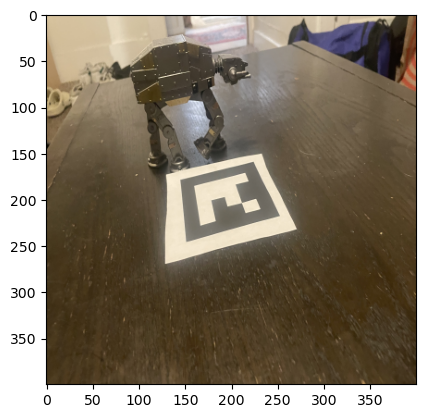

In [6]:
# Visualize some samples of the resized dataset

plt.imshow(atat_dataset[5].cpu().numpy())

In [7]:
batch_size = 10000
lafufu_mlp_default_params = {
    "name" : "lafufu_default",
    "n_layers" : 8,
    "width" : 256,
    "L_coords" : 10,
    "L_direction" : 4,
    "iter" : 10001,
    "lr" : 5e-4,
    "near" : 0.02,
    "far" : 0.5,
    "n_samples" : 32,
    "batch_size" : 10000
}

atat_mlp_default_params = {
    "name" : "atat_default",
    "n_layers" : 8,
    "width" : 256,
    "L_coords" : 10,
    "L_direction" : 4,
    "iter" : 10001,
    "lr" : 5e-4,
    "near" : 0.0213,
    "far" : 0.2754,
    "n_samples" : 64,
    "batch_size" : 10000
}

#lafufu_mlp_3d_default = MLP_3D(lafufu_mlp_default_params).to(device)
atat_mlp_3d_default = MLP_3D(lafufu_mlp_default_params).to(device)

Coordinate Encoding Dim:  63
Direction Encoding Dim:  27


In [8]:
#  Load a presaved model
# state_dict = torch.load(f'{MODELS_DIR}/atat_mlp_trained_fixed.pth', map_location=torch.device('mps'))
# atat_mlp_3d_default.load_state_dict(state_dict)
# atat_mlp_3d_default.eval()

In [ ]:
model = atat_mlp_3d_default # change this however you want
params = atat_mlp_default_params
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), params["lr"])
def train(model, dataset, val_dataset, params, plot_psnr=False, test_render_idx=5, validate=False):
    # Train Loop
    model.train()

    num_iterations = params["iter"]
    batch_size = params["batch_size"]
    near = params["near"]
    far = params["far"]
    n_samples = params["n_samples"]
    initial_lr = params['lr']

    # Defining Criterion: We use PSNR (Peak Signal to Noise Ratio). This is a modified MSE loss that is computed in the training loop.


    # # LR scheduling. Will be 0.1 * initial LR by the end of optimization
    # final_lr = initial_lr * 0.1
    # gamma = (final_lr / initial_lr) ** (1.0 / num_iterations)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    iteration_history = []
    psnr_history = []

    iteration_history_val = []
    psnr_history_val = []
    for i in range(num_iterations):
        optimizer.zero_grad()

        ray_origins, ray_directions, pixels = dataset.sample_rays(batch_size)
        points_along_rays = sample_along_rays(ray_origins, ray_directions, perturb=True, near=near, far=far, n_samples=n_samples)

        ray_directions_normalized = ray_directions[:, None, :].repeat(1, n_samples, 1).reshape((-1, 3))
        ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)
        points_along_rays = torch.tensor(points_along_rays, dtype=torch.float32).to(device)
        pixels = torch.tensor(pixels, dtype=torch.float32).to(device)

        predicted_densities, predicted_rgbs = model(points_along_rays, ray_directions_normalized)
        predicted_densities = predicted_densities.view((batch_size, n_samples, 1))
        predicted_rgbs = predicted_rgbs.view((batch_size, n_samples, 3))

        predicted_pixels = volrend(predicted_densities, predicted_rgbs, step_size=model.step_size)


        loss = criterion(predicted_pixels, pixels)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        psnr = 10 * torch.log10(1.0 / loss)

        print(f"ITERATION {i}, TRAINING PSNR: ", psnr.item())


        if validate:
            avg_val_psnr = compute_avg_val_psnr(model, val_dataset, params)
            print(f"ITERATION {i}, VALIDATION PSNR: ", avg_val_psnr.item())

        if i % 100 == 0:
            rendered_test_img = render_eval_image(model, dataset, params, test_idx=test_render_idx, chunk_size=512)
            model.train()
            rendered_test_img = rendered_test_img.cpu().numpy()
            ut.save_img(rendered_test_img, f"{RENDER_OUTPUT_DIR}/iter={i}.jpg")


        iteration_history.append(i)
        psnr_history.append(psnr)

        if validate:
            iteration_history_val.append(i)
            psnr_history_val.append(avg_val_psnr)

    return iteration_history, psnr_history, iteration_history_val, psnr_history_val

def compute_avg_val_psnr(model, val_dataset, params):
    val_psnrs = []
    N = len(val_dataset)
    for i in range(N):
        val_img = val_dataset.images[i]
        val_c2w = val_dataset.c2ws[i]

        predicted_pixels, pixels = render_partial_image(model, val_dataset, params, test_idx=i, c2w=val_c2w, n_rays=1000)
        loss = criterion(pixels, predicted_pixels)
        psnr = 10 * torch.log10(1.0 / loss)
        val_psnrs.append(psnr)
    val_psnrs = torch.tensor(val_psnrs, dtype=torch.float32).to(device)
    return torch.mean(val_psnrs)
    
def render_partial_image(model, dataset, params, test_idx=0, c2w=None, n_rays=1000):
    model.eval()
    near = params["near"]
    far = params["far"]
    n_samples = params["n_samples"]

    with torch.no_grad():

        ray_origins, ray_directions, pixels = dataset.sample_partial_rays_from_img(n_rays, c2w=c2w, img_idx=test_idx)
        points_along_rays = sample_along_rays(ray_origins, ray_directions, perturb=False, near=near, far=far, n_samples=n_samples)

        ray_directions_normalized = ray_directions[:, None, :].repeat(1, n_samples, 1).reshape((-1, 3))
        ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)
        points_along_rays = torch.tensor(points_along_rays, dtype=torch.float32).to(device)
        pixels = torch.tensor(pixels, dtype=torch.float32).to(device)

        predicted_densities, predicted_rgbs = model(points_along_rays, ray_directions_normalized)
        predicted_densities = predicted_densities.view((n_rays, n_samples, 1))
        predicted_rgbs = predicted_rgbs.view((n_rays, n_samples, 3))

        predicted_pixels = volrend(predicted_densities, predicted_rgbs, step_size=model.step_size)

        return predicted_pixels, pixels

    model.train()
    
def render_eval_image(model, dataset, params, test_idx=0, chunk_size=512, c2w=None):
    model.eval()
    near = params["near"]
    far = params["far"]
    n_samples = params["n_samples"]


    ray_origins, ray_directions = dataset.sample_all_rays_from_img(test_idx, c2w=c2w)
    img = dataset[test_idx]
    H, W = img.shape[:2]

    rendered_img = torch.zeros((H * W, 3), dtype=torch.float32).to(device)


    with torch.no_grad():
        for i in range(0, H * W, chunk_size):
            ray_origins_chunk = ray_origins[i : i + chunk_size]
            ray_directions_chunk = ray_directions[i : i + chunk_size]
            current_chunk_size = ray_directions_chunk.shape[0]



            points_along_rays_chunk = sample_along_rays(
                ray_origins_chunk,
                ray_directions_chunk,
                perturb=False,
                near = near,
                far=far,
                n_samples=n_samples
            )

            ray_directions_normalized = ray_directions_chunk[:, None, :].repeat(1, n_samples, 1).reshape((-1, 3))


            points_along_rays_chunk = torch.tensor(points_along_rays_chunk, dtype=torch.float32).to(device)
            ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)

            predicted_densities, predicted_rgbs = model(points_along_rays_chunk, ray_directions_normalized)
            predicted_densities = predicted_densities.view((current_chunk_size, n_samples, 1))
            predicted_rgbs = predicted_rgbs.view((current_chunk_size, n_samples, 3))

            predicted_pixels = volrend(predicted_densities, predicted_rgbs, step_size=model.step_size)
            rendered_img[i : i + chunk_size] = predicted_pixels

    model.train()

    return rendered_img.view((H, W, 3))

# test_model = MLP_3D(truck_mlp_default_params).to(device)
# test_model.load_state_dict(torch.load("models/truck_mlp_trained_1.pth", weights_only=True))
# test_model.eval()

# test_img = render_eval_image(test_model, truck_dataset, truck_mlp_default_params, 5, 1024)
# ut.save_img(test_img, "data/images/test_lego_renders/trained_mlp_lego_sanity_check.jpg")

In [10]:
iteration_history, psnr_history, iteration_history_val, psnr_history_val = train(model, atat_dataset, atat_dataset_val, params, validate=True)

/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_along_rays = torch.tensor(points_along_rays, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.

ITERATION 0, TRAINING PSNR:  7.418668746948242


/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_along_rays = torch.tensor(points_along_rays, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tor

ITERATION 0, VALIDATION PSNR:  8.318503379821777


/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_along_rays_chunk = torch.tensor(points_along_rays_chunk, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_73450/702229931.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)


Reconstructed image saved as results/atat_test_renders_default/iter=0.jpg
ITERATION 1, TRAINING PSNR:  7.890512943267822
ITERATION 1, VALIDATION PSNR:  8.87540054321289
ITERATION 2, TRAINING PSNR:  8.249618530273438
ITERATION 2, VALIDATION PSNR:  9.414629936218262
ITERATION 3, TRAINING PSNR:  8.78685188293457
ITERATION 3, VALIDATION PSNR:  10.150924682617188
ITERATION 4, TRAINING PSNR:  9.485391616821289
ITERATION 4, VALIDATION PSNR:  10.99907112121582
ITERATION 5, TRAINING PSNR:  10.356088638305664
ITERATION 5, VALIDATION PSNR:  12.111381530761719
ITERATION 6, TRAINING PSNR:  11.483330726623535
ITERATION 6, VALIDATION PSNR:  13.191237449645996
ITERATION 7, TRAINING PSNR:  12.562073707580566
ITERATION 7, VALIDATION PSNR:  13.676373481750488
ITERATION 8, TRAINING PSNR:  13.501591682434082
ITERATION 8, VALIDATION PSNR:  13.356569290161133
ITERATION 9, TRAINING PSNR:  13.087844848632812
ITERATION 9, VALIDATION PSNR:  12.44959831237793
ITERATION 10, TRAINING PSNR:  12.429448127746582
ITERA

In [ ]:
torch.save(atat_mlp_3d_default.state_dict(), f"{MODELS_DIR}/atat_mlp_trained_fixed.pth")

PSNR curve saved to results/plots/atat_model_fixed.jpg


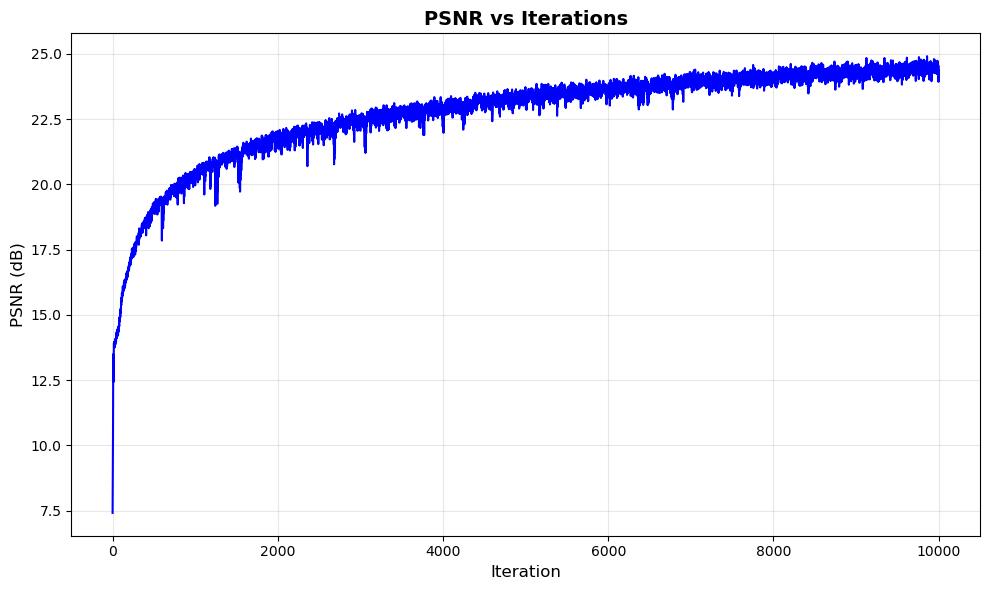

PSNR curve saved to results/plots/atat_model_fixed_loss.jpg


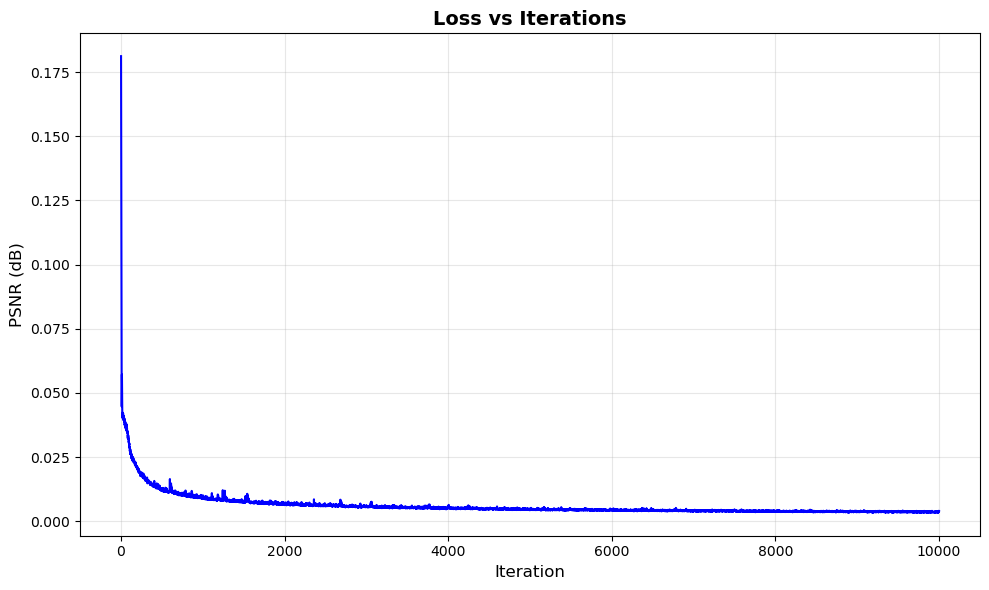

In [ ]:

def plot_psnr_curve(iteration_history, psnr_history, title="PSNR vs Iterations", save_path=None):

    if len(psnr_history) > 0 and hasattr(psnr_history[0], 'item'):
        psnr_values = [psnr.item() if hasattr(psnr, 'item') else float(psnr) for psnr in psnr_history]
    else:
        psnr_values = [float(psnr) for psnr in psnr_history]
    
    iterations = np.array(iteration_history)
    psnr_array = np.array(psnr_values)
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, psnr_array, linewidth=1.5, color='blue')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('PSNR (dB)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"PSNR curve saved to {save_path}")
    
    plt.show()

plot_psnr_curve(iteration_history, psnr_history, save_path=f"{PLOTS_DIR}/atat_model_fixed.jpg")

loss_history = [10 ** (-psnr / 10) for psnr in psnr_history]

plot_psnr_curve(iteration_history, loss_history, title="Loss vs Iterations", save_path=f"{PLOTS_DIR}/atat_model_fixed_loss.jpg")

In [35]:

def look_at_origin(pos):
    # Camera looks towards the origin
    forward = -pos / np.linalg.norm(pos)  # Normalize the direction vector

    # Define up vector (assuming y-up)
    up = np.array([0, 1, 0])

    # Compute right vector using cross product
    right = np.cross(up, forward)
    right = right / np.linalg.norm(right)

    # Recompute up vector to ensure orthogonality
    up = np.cross(forward, right)

    # Create the camera-to-world matrix
    c2w = np.eye(4)
    c2w[:3, 0] = right
    c2w[:3, 1] = up
    c2w[:3, 2] = forward
    c2w[:3, 3] = pos

    return c2w

def rot_x(phi):
    """Rotation around X-axis (vertical orbit - over and under object)"""
    return np.array([
        [1, 0, 0, 0],
        [0, math.cos(phi), -math.sin(phi), 0],
        [0, math.sin(phi), math.cos(phi), 0],
        [0, 0, 0, 1],
    ])

def rot_y(phi):
    """Rotation around Y-axis (horizontal orbit - spinning around object)"""
    return np.array([
        [math.cos(phi), 0, math.sin(phi), 0],
        [0, 1, 0, 0],
        [-math.sin(phi), 0, math.cos(phi), 0],
        [0, 0, 0, 1],
    ])

def rot_z(phi):
    """Rotation around Z-axis (tilted orbit)"""
    return np.array([
        [math.cos(phi), -math.sin(phi), 0, 0],
        [math.sin(phi), math.cos(phi), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])

# Generate spherical render poses
START_POS = c2ws_train[5][:3, 3]
NUM_SAMPLES = 60

c2ws_spherical = []
for phi in np.linspace(0, 2 * np.pi, NUM_SAMPLES, endpoint=False):
    c2w = look_at_origin(START_POS)
    
    # Choose which rotation you want:
    extrinsic = rot_z(phi) @ c2w 
    
    
    c2ws_spherical.append(extrinsic)

c2ws_spherical = np.array(c2ws_spherical)

In [ ]:
# Spherical Rendering
import imageio
from pathlib import Path


spherical_render_path = "results/spherical_render/"



def create_spherical_render(c2w_test, out_path=spherical_render_path, rotate = None):
    for i, c2w in enumerate(c2w_test):
        test_img = render_eval_image(model, atat_dataset, params, test_idx=5, c2w=c2w).cpu().numpy()

        if rotate:
            test_img = np.rot90(test_img, k=1)
        ut.save_img(test_img, save_path=f"{out_path}/{i}.jpg")

create_spherical_render(c2w_test=c2ws_spherical, rotate=True)


# Generated using Claude. This is presentation portion of project
def create_gif_from_images(image_folder, output_path, fps=10):
    """Create a GIF from rendered images"""
    images = sorted(Path(image_folder).glob('*.jpg'))
    images = sorted(images, key=lambda x: int(x.stem))

    frames = [imageio.imread(str(img)) for img in images]
    imageio.mimsave(output_path, frames, fps=fps, loop=0)
    print(f"GIF saved to {output_path}")

#create_gif_from_images(spherical_render_path, f'{spherical_render_path}/lego_spherical.gif', fps=10)
create_gif_from_images(SPHERICAL_RENDER_DIR, f'{SPHERICAL_RENDER_DIR}/atat_spherical_4.gif', fps=10)


/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_87523/702229931.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_along_rays_chunk = torch.tensor(points_along_rays_chunk, dtype=torch.float32).to(device)
/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_87523/702229931.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions_normalized = torch.tensor(ray_directions_normalized, dtype=torch.float32).to(device)


Reconstructed image saved as results/spherical_render//0.jpg
Reconstructed image saved as results/spherical_render//1.jpg
Reconstructed image saved as results/spherical_render//2.jpg
Reconstructed image saved as results/spherical_render//3.jpg
Reconstructed image saved as results/spherical_render//4.jpg
Reconstructed image saved as results/spherical_render//5.jpg
Reconstructed image saved as results/spherical_render//6.jpg
Reconstructed image saved as results/spherical_render//7.jpg
Reconstructed image saved as results/spherical_render//8.jpg
Reconstructed image saved as results/spherical_render//9.jpg
Reconstructed image saved as results/spherical_render//10.jpg
Reconstructed image saved as results/spherical_render//11.jpg
Reconstructed image saved as results/spherical_render//12.jpg
Reconstructed image saved as results/spherical_render//13.jpg
Reconstructed image saved as results/spherical_render//14.jpg
Reconstructed image saved as results/spherical_render//15.jpg
Reconstructed imag

/var/folders/3n/qlh06nts447cksv372k2xtvc0000gn/T/ipykernel_87523/615126259.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(str(img)) for img in images]


GIF saved to results/spherical_render//atat_spherical_4.gif
